<h1>Оптимизация работы и маркетинговой стратегии приложения Procrastinate Pro+</h1>

### Загрузка данных и подготовка их к анализу

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import cProfile
from datetime import datetime, timedelta
from scipy.stats import mode
from google.colab import drive

In [2]:
drive.mount('/gdrive')

orders_id = '1G20UMQogAtvMTfILVO-_nuLT27Pq_UXb'
costs_id = '1WfZB7B4V8gJEN9ASPnZtdc1C2hM2QG3f'
visits_id = '1TxVxrsn-0uscZqoZ8xpgvgEi9rJnI93p'

link_orders = 'https://drive.google.com/uc?id=' + orders_id
link_costs = 'https://drive.google.com/uc?id=' + costs_id
link_visits = 'https://drive.google.com/uc?id=' + visits_id

visits = pd.read_csv(link_visits, error_bad_lines=False)
orders = pd.read_csv(link_orders, error_bad_lines=False)
costs = pd.read_csv(link_costs, error_bad_lines=False)

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


<ipython-input-2-51b36bef1a53>:11: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  visits = pd.read_csv(link_visits, error_bad_lines=False)
<ipython-input-2-51b36bef1a53>:12: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  orders = pd.read_csv(link_orders, error_bad_lines=False)
<ipython-input-2-51b36bef1a53>:13: FutureWarning: The error_bad_lines argument has been deprecated and will be removed in a future version. Use on_bad_lines in the future.


  costs = pd.read_csv(link_costs, error_bad_lines=False)


In [3]:

display(visits.head(3))
display(orders.head(3))
display(costs.head(3))

User Id         Region  Device  Channel        Session Start  \
0  981449118918  United States  iPhone  organic  2019-05-01 02:36:01   
1  278965908054  United States  iPhone  organic  2019-05-01 04:46:31   
2  590706206550  United States     Mac  organic  2019-05-01 14:09:25   

           Session End  
0  2019-05-01 02:45:01  
1  2019-05-01 04:47:35  
2  2019-05-01 15:32:08

User Id             Event Dt  Revenue
0  188246423999  2019-05-01 23:09:52     4.99
1  174361394180  2019-05-01 12:24:04     4.99
2  529610067795  2019-05-01 11:34:04     4.99

dt   Channel  costs
0  2019-05-01  FaceBoom  113.3
1  2019-05-02  FaceBoom   78.1
2  2019-05-03  FaceBoom   85.8

In [4]:
for df in [costs]:
    print(df.isnull().sum())
    print(df.duplicated().sum())

for df in [orders]:
    print(df.isnull().sum())
    print(df.duplicated().sum())

for df in [visits]:
    print(df.isnull().sum())
    print(df.duplicated().sum())

dt         0
Channel    0
costs      0
dtype: int64
0
User Id     0
Event Dt    0
Revenue     0
dtype: int64
0
User Id          0
Region           0
Device           0
Channel          0
Session Start    0
Session End      0
dtype: int64
0


В данных нет пропусков и дубликатов.

In [5]:
costs['dt'] = pd.to_datetime(costs['dt'])
visits['Session Start'] = pd.to_datetime(visits['Session Start'])
visits['Session End'] = pd.to_datetime(visits['Session End'])
orders['Event Dt'] = pd.to_datetime(orders['Event Dt'])

visits['Channel'] = visits['Channel'].astype('category')
visits['Region'] = visits['Region'].astype('category')
visits['Device'] = visits['Device'].astype('category')
costs['Channel'] = costs['Channel'].astype('category')

visits.columns = [x.lower().replace(' ', '_') for x in visits.columns.values]
orders.columns = [x.lower().replace(' ', '_') for x in orders.columns.values]
costs.columns = [x.lower().replace(' ', '_') for x in costs.columns.values]

visits.region = visits.region.str.lower()
visits.device = visits.device.str.lower()
visits.channel = visits.channel.str.lower()
costs.channel = costs.channel.str.lower()

In [6]:
for df in [costs]:
    print(df.dtypes)

for df in [visits]:
    print(df.dtypes)

for df in [orders]:
    print(df.dtypes)

dt         datetime64[ns]
channel            object
costs             float64
dtype: object
user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object
user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object


In [7]:
print(visits['user_id'].duplicated(keep=False).sum())
print(orders['user_id'].duplicated(keep=False).sum())

237398
37072


В таблицах ‘visits’ и ‘orders’ дубликаты отсутствуют, это указывает на то, что один и тот же пользователь (‘user_id’) мог несколько раз посещать сайт или совершать покупки.

### Зададим функции для расчета и анализа.

In [8]:
def get_profiles(visits, orders, costs):

    profiles = (
        visits.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index())

    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['dt'] = pd.to_datetime(profiles['dt'])
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    ad_costs = costs.merge(new_users, on=['dt', 'channel'], how='left')
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

profiles = get_profiles(visits, orders, costs)
print(profiles.head(2))

   user_id            first_ts   channel  device         region         dt  \
0   599326 2019-05-07 20:58:57  faceboom     mac  united states 2019-05-07   
1  4919697 2019-07-09 12:46:07  faceboom  iphone  united states 2019-07-09   

                month  payer  acquisition_cost  
0 2019-05-07 20:58:57   True          1.088172  
1 2019-07-09 12:46:07  False          1.107237  


Определим период времени, для которого сделаем прогноз:

In [9]:
observation_date = datetime(2019, 11, 1).date()
horizon_days = 14

Проведем расчет удержания пользователей, чтобы понять, как долго клиенты или пользователи продолжают пользоваться продуктом.

In [10]:
def get_retention(
    profiles,
    visits,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    dimensions = ['payer'] + dimensions
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    result_raw = result_raw.merge(
        visits[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)
    result_in_time = group_by_dimensions(result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

Пропишем функцию для расчета конверсии для определения эффективности маркетинговых кампаний, улучшения пользовательского опыта и увеличения доходов. Она также может помочь выявить “слабые” места в процессах и стратегиях.

In [11]:
def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    first_purchases = (
        orders.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left')


    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique')

        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)

        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result


    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days)

    return result_raw, result_grouped, result_in_time

Пропишем функцию для расчета жизненной ценности клиента и эффективности.

In [12]:
def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )

    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']


    def group_by_dimensions(df, dims, horizon_days):

        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )

        result = result.fillna(0).cumsum(axis=1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )

        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes

        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'}))

        roi = result.div(cac['cac'], axis=0)

        roi = roi[~roi['cohort_size'].isin([np.inf])]

        roi['cohort_size'] = cohort_sizes

        roi['cac'] = cac['cac']

        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        return result, roi

    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days)

    if 'cohort' in dimensions:
        dimensions = []

    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days)

    return (
        result_raw,
        result_grouped,
        result_in_time,
        roi_grouped,
        roi_in_time,
    )

Функции для визуализации:

In [13]:
def plot_retention(retention, retention_history, horizon, window=7):

    plt.figure(figsize=(15, 10))

    retention = retention.drop(columns=['cohort_size', 0])

    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание платящих пользователей')

    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Удержание неплатящих пользователей')

    ax3 = plt.subplot(2, 2, 3)

    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]

    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon))

    ax4 = plt.subplot(2, 2, 4, sharey=ax3)

    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax4)
    plt.xlabel('Дата привлечения')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon))

    plt.tight_layout()
    plt.show()

In [14]:
def plot_conversion(conversion, conversion_history, horizon, window=7):

    plt.figure(figsize=(15, 5))
    conversion = conversion.drop(columns=['cohort_size'])

    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]]

    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('Конверсия пользователей')

    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [

        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

In [15]:
def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    plt.figure(figsize=(20, 10))

    ltv = ltv.drop(columns=['cohort_size'])
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    cac_history = roi_history[['cac']]

    roi = roi.drop(columns=['cohort_size', 'cac'])
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('LTV')

    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax2)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon))

    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax3)
    plt.xlabel('Дата привлечения')
    plt.title('Динамика стоимости привлечения пользователей')

    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм')
    plt.title('ROI')

    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon))

    plt.tight_layout()
    plt.show()

Вычислим среднее значение Lifetime Value, или “ценность клиента за всю жизнь” и среднюю продолжительность жизни клиентов.

In [16]:
def get_ltv_and_lifespan(visits, orders):

    revenue_per_customer = orders.groupby('user_id')['revenue'].sum()

    lifespan_per_customer = visits.groupby('user_id')['session_start'].agg(['min', 'max'])

    lifespan_per_customer['lifespan'] = (lifespan_per_customer['max'] - lifespan_per_customer['min']).dt.days
    lifespan_per_customer['lifespan'] = lifespan_per_customer['lifespan'].replace(0, 1)

    ltv_data = pd.merge(revenue_per_customer, lifespan_per_customer['lifespan'], on='user_id')
    ltv_data['LTV'] = ltv_data['revenue'] / ltv_data['lifespan']

    return ltv_data['LTV'].mean(), ltv_data['lifespan'].mean()

### Исследовательский анализ данных

Составили профили пользователей и определяем минимальную и максимальную дату вовлечения:

In [17]:
profiles = get_profiles(visits, orders, costs)
print(profiles.first_ts.min())
print(profiles.first_ts.max())

2019-05-01 00:00:41
2019-10-27 23:59:04


Минимальная и максимальная даты определены и совподают с предоставленной информацией.

Проведем анализ источников, устройств и регионов пользователей:

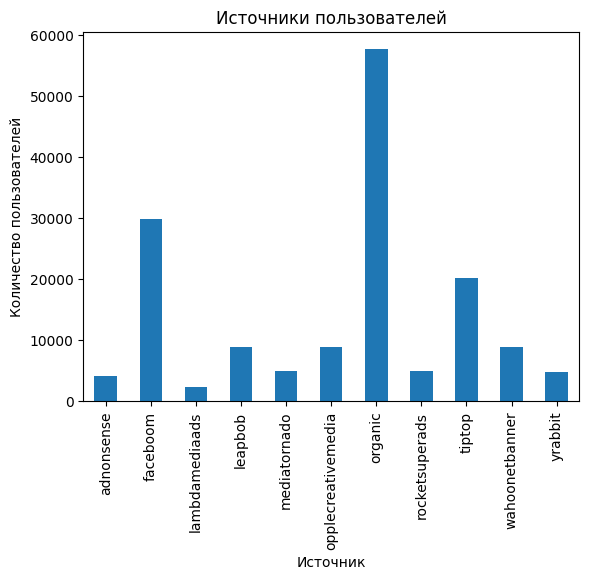

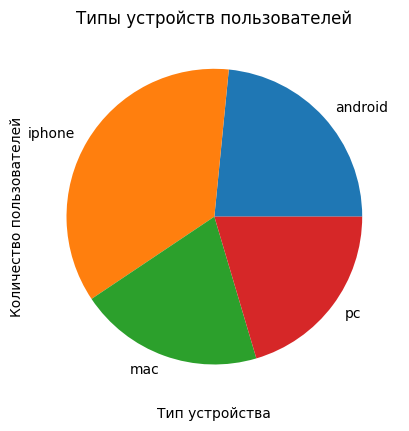

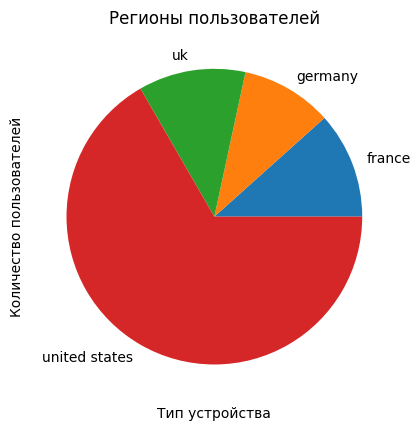

In [18]:
def analyze_sources(visits):
    channel_users = visits.groupby('channel')['user_id'].nunique()
    return channel_users

def analyze_devices(visits):
    device_users = visits.groupby('device')['user_id'].nunique()
    return device_users

def analyze_region(visits):
    region_users = visits.groupby('region')['user_id'].nunique()
    return region_users

def plot_results(data, title, kind='bar'):
    data.plot(kind=kind)
    plt.xlabel('Источник' if kind == 'bar' else 'Тип устройства' if kind == 'pie' else 'Регион')
    plt.ylabel('Количество пользователей')
    plt.title(title)
    plt.xticks(rotation=90 if kind == 'bar' else None)
    plt.show()


channel_data = analyze_sources(visits)
plot_results(channel_data, 'Источники пользователей')

device_data = analyze_devices(visits)
plot_results(device_data, 'Типы устройств пользователей', kind='pie')

region_data = analyze_region(visits)
plot_results(region_data, 'Регионы пользователей', kind='pie')

Чаще всего пользователи посещают канал organic и FaceBoom.
По типу устройства предпочтителен iPhone.
Преобладающая часть пользователей с Соединенных Штатов.

Вычислим количество платящих пользователей и их долю от общего числа пользователей по регионам, девайсам и каналам.

In [19]:
total_users_by_country = profiles.groupby('region')['user_id'].nunique()
paying_users_by_country = profiles[profiles['payer']].groupby('region')['user_id'].nunique()

paying_share = (paying_users_by_country / total_users_by_country)*100

result = pd.DataFrame({
        'Total Users': total_users_by_country,
        'Paying Users': paying_users_by_country,
        'Paying Share': paying_share
    })

display(result)

Total Users  Paying Users  Paying Share
region                                                
france               17450           663      3.799427
germany              14981           616      4.111875
uk                   17575           700      3.982930
united states       100002          6902      6.901862

Соединенные Штаты имеют наибольшее количество общих пользователей и платящих, что составляет самый высокий процент среди всех регионов.

Франция, Германия и Великобритания имеют схожие доли платящих пользователей, составляющие около 4% от общего числа пользователей.

Несмотря на то, что Франция и Великобритания имеют больше общих пользователей, чем Германия, количество платящих пользователей в этих странах примерно одинаково.

In [20]:
# Расчет платящих пользователей по каналам:

paying_users_by_channel = profiles[profiles['payer']].groupby('channel')['user_id'].nunique()
total_users_by_channel = profiles.groupby('channel')['user_id'].nunique()
paying_share = (paying_users_by_channel / total_users_by_channel)*100

result = pd.DataFrame({
        'Total Users': total_users_by_channel,
        'Paying Users': paying_users_by_channel,
        'Paying Share': paying_share
    })

display(result)

Total Users  Paying Users  Paying Share
channel                                                    
adnonsense                 3880           440     11.340206
faceboom                  29144          3557     12.204914
lambdamediaads             2149           225     10.469986
leapbob                    8553           262      3.063253
mediatornado               4364           156      3.574702
opplecreativemedia         8605           233      2.707728
organic                   56439          1160      2.055316
rocketsuperads             4448           352      7.913669
tiptop                    19561          1878      9.600736
wahoonetbanner             8553           453      5.296387
yrabbit                    4312           165      3.826531

В Faceboom самая высокая доля платящих пользователей, что объясняется затратами на рекламу и большим количеством посещений канала.

Несмотря на небольшое количество посещений, доля тех, кто платит через эти каналы: Аdnonsense, lambdamediaАds , высока.

Organic и Opplecreativemedia имеют наименьшую долю платящих пользователей, что указывает на необходимость улучшения стратегии привлечения клиентов для этих каналов.

In [21]:
# Расчет платящих пользователей по устройствам:

paying_users_by_device = profiles[profiles['payer']].groupby('device')['user_id'].nunique()
total_users_by_device = profiles.groupby('device')['user_id'].nunique()

paying_share = (paying_users_by_device / total_users_by_device)*100

result = pd.DataFrame({
        'Total Users': total_users_by_device,
        'Paying Users': paying_users_by_device,
        'Paying Share': paying_share
    })

display(result)

Total Users  Paying Users  Paying Share
device                                          
android        35032          2050      5.851793
iphone         54479          3382      6.207897
mac            30042          1912      6.364423
pc             30455          1537      5.046790

Mac имеет наивысшую долю платящих пользователей, что указывает на высокую эффективность этого устройства в привлечении платящих пользователей.

На PC  и Android приходится наименьшая доля платящих пользователей, что может свидетельствовать о необходимости совершенствования стратегий привлечения клиентов для этих устройств.

Несмотря на то, что iphone имеет наибольшее количество пользователей, доля платящих ниже, чем у mac.

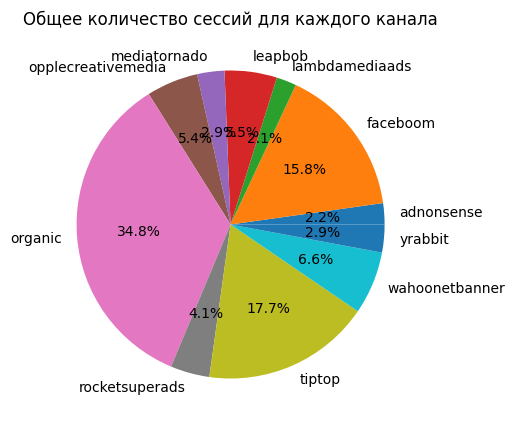

In [22]:
# Подсчет количества сессий для каждого канала:

total_sessions = visits.groupby('channel')['session_start'].count()

plt.figure(figsize=(10, 5))
plt.pie(total_sessions, labels = total_sessions.index, autopct='%1.1f%%', labeldistance=1.1)
plt.title('Общее количество сессий для каждого канала')
plt.show()

Большее количество сессий было инициировано через канал TipTop, FaceBoom и organic.

Вычислим ключевые метрики для бизнеса:

In [23]:
ltv, lifespan = get_ltv_and_lifespan(visits, orders)

print("Средний LTV:", ltv)
print("Средняя продолжительность жизни:", lifespan)

Средний LTV: 2.1745437941126973
Средняя продолжительность жизни: 48.06924895845062


LTV составляет 2.2 единицы дохода за всё время взаимодействия с продуктом.
Средний срок жизни пользователя составляет 48 дней. От общего числа малая доля пользователей совершает покупки.

In [24]:
# Расчет среднего чека (AOV)
AOV = orders['revenue'].sum() / orders['event_dt'].nunique()

# Расчет среднего количества заказов
avg_orders = orders.groupby('user_id')['event_dt'].nunique().mean()

# Расчет AGM (Средний коэффициент прибыльности)
AGM = (orders['revenue'].sum() - costs['costs'].sum()) / orders['revenue'].sum()

print(f"AOV платящих пользователей: {AOV}")
print(f"Среднее количество заказов платящих пользователей: {avg_orders}")
print(f"AGM платящих пользователей: {AGM}")

AOV платящих пользователей: 5.377160072703733
Среднее количество заказов платящих пользователей: 4.52786848327891
AGM платящих пользователей: 0.5115026248955375


В среднем клиент делает 4-5 заказов. Средний коэффициент прибыльности (AGM) равный 0.5115 означает, что каждый потраченный доллар приносит прибыль в размере 51 цента.

Визуализируем, как меняется количество заказов в течение времени на недельной основе. Это поможет для анализа сезонности, эффективности маркетинговых кампаний и изменений на сайте.

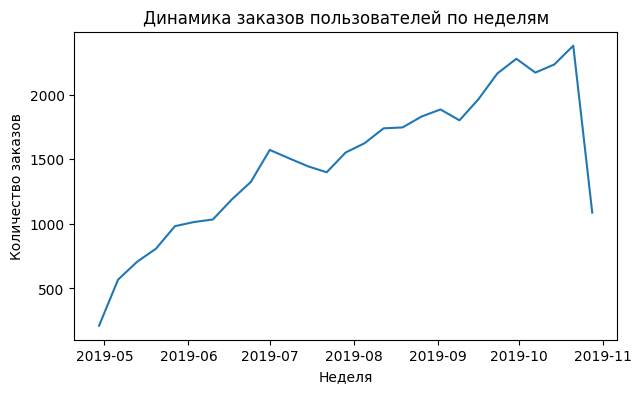

In [25]:
# Динамика заказов пользователей по неделям:
orders['order_week'] = orders['event_dt'].dt.to_period('W')
order_counts = orders.groupby('order_week')['event_dt'].count()

plt.figure(figsize=(7, 4))
plt.plot(order_counts.index.to_timestamp(), order_counts.values)
plt.xlabel('Неделя')
plt.ylabel('Количество заказов')
plt.title('Динамика заказов пользователей по неделям')
plt.show()

Количество заказов с течением времени увеличивается. В конце октября заметен резкий спад.

Проанализируем поведение пользователей и выявим наиболее выгодных клиентов.

In [26]:
# Группируем данные по 'user_id', подсчитываем общее количество заказов и сумму покупок для каждого пользователя:

user_analysis = orders.groupby('user_id').agg({
    'revenue': ['count', 'sum']
    }).reset_index()

user_analysis.columns = ['user_id', 'total_orders', 'total_revenue']
merged_data = pd.merge(user_analysis, visits, on='user_id', how='left')

merged_data = merged_data.groupby('user_id').agg({
    'total_orders': 'first',
    'total_revenue': 'first',
    'region': pd.Series.mode,
    'device': pd.Series.mode,
    'channel': pd.Series.mode,
    'session_start': 'min',
    'session_end': 'max'
}).reset_index()

sorted_user_analysis = merged_data.sort_values(by='total_revenue', ascending=False)
display(sorted_user_analysis.head(10))

user_id  total_orders  total_revenue         region   device  \
8086  905723035964            12         149.88        germany       pc   
5766  649616333931            10         140.90         france  android   
8018  897756565239            18         134.82  united states   iphone   
5698  641347422979            17         131.83  united states   iphone   
4880  547684681026            17         129.83  united states  android   
4375  493030266041            17         129.83  united states       pc   
7104  798446502122            16         125.84             uk      mac   
5814  654372019956             7         124.93             uk       pc   
7167  805008658262            14         124.86         france   iphone   
5517  621646182958            15         120.85  united states   iphone   

             channel       session_start         session_end  
8086         organic 2019-05-04 23:28:16 2019-10-24 18:48:39  
5766  lambdamediaads 2019-07-03 00:04:29 2019-10-16 11:06:36  
8018          tiptop 2019-06-14 01:33:57 2019-10-15 15:25:51  
5698         organic 2019-05-18 04:05:39 2019-10-14 01:16:00  
4880          tiptop 2019-05-28 09:43:38 2019-10-28 20:41:57  
4375         organic 2019-05-27 11:10:48 2019-10-26 04:27:29  
7104         organic 2019-05-15 19:46:32 2019-10-30 04:18:52  
5814  lambdamediaads 2019-05-04 22:38:20 2019-10-07 10:36:24  
7167         organic 2019-06-10 21:41:43 2019-10-29 09:02:36  
5517          tiptop 2019-05-04 23:42:15 2019-09-16 01:50:35

Вывели Топ-10 пользователей по уровню оплаты. Большинство из них перешли с органического канала.

Визуализируем, как меняется прибыль в течение времени на недельной и месячной основе. Это может помочь нам спрогнозировать будущую прибыль и спланировать бюджет.

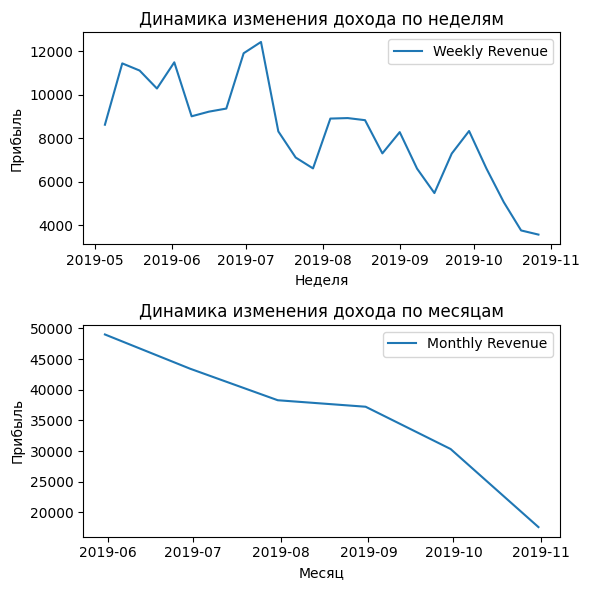

In [27]:
# Динамика изменений прибыли:

combined = pd.merge(profiles, orders, on='user_id')
weekly_revenue = combined.resample('W', on='first_ts')['revenue'].sum()
monthly_revenue = combined.resample('M', on='first_ts')['revenue'].sum()

fig, ax = plt.subplots(2, 1, figsize=(6, 6))
ax[0].plot(weekly_revenue.index, weekly_revenue.values, label='Weekly Revenue')
ax[0].set_title('Динамика изменения дохода по неделям')
ax[0].set_xlabel('Неделя')
ax[0].set_ylabel('Прибыль')
ax[0].legend()

ax[1].plot(monthly_revenue.index, monthly_revenue.values, label='Monthly Revenue')
ax[1].set_title('Динамика изменения дохода по месяцам')
ax[1].set_xlabel('Месяц')
ax[1].set_ylabel('Прибыль')
ax[1].legend()
plt.tight_layout()
plt.show()

В середине июля мы наблюдаем заметный пик прибыли. Увеличение активности пользователей в этот период, может быть, связано с успешной рекламной кампанией или сезонным фактором. Этот пик указывает на то, что стратегии, применяемые в этот период, были особенно эффективными, и их можно использовать в будущем для увеличения прибыли. Прибыль с течением времени падает.

### Маркетинг

Проведем расчет общих затрат и количество уникальных уровней затрат в разных каналах, чтобы увидеть, какие каналы требуют больше инвестиций и как это соотносится с результатами, которые они приносят. Это может помочь нам определить, какие каналы дают лучший возврат инвестиций и где стоит увеличить или уменьшить затраты.

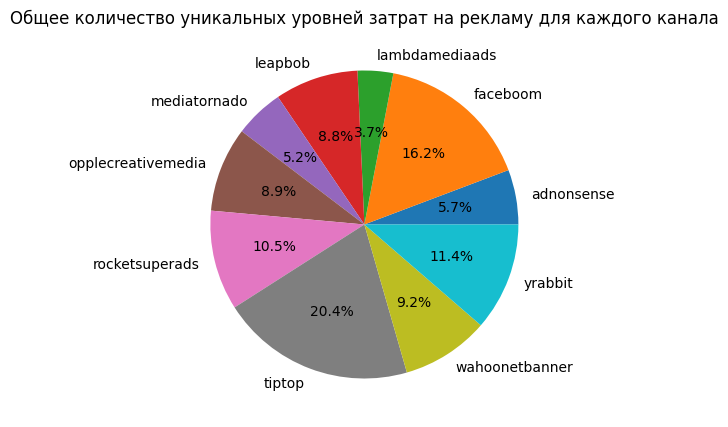

In [28]:
# Расчет уникальных значений затрат на рекламу для каждого канала:

total_costs_nunique = costs.groupby('channel')['costs'].nunique()
total_costs = costs.groupby('channel')['costs'].sum()

plt.figure(figsize=(10, 5))
plt.pie(total_costs_nunique, labels = total_costs_nunique.index, autopct='%1.1f%%')
plt.title('Общее количество уникальных уровней затрат на рекламу для каждого канала')
plt.show()

На диаграмме отображено количество уникальных уровней затрат на рекламу для каждого канала. Каждый уровень учитывается только один раз, даже если он встречается в данных несколько раз.

Таким образом, диаграмма показывает разнообразие затрат на рекламу для каждого канала. Чем больше процент, тем затраты на этот канал более разнообразны. Чем меньше процент, тем затраты на этот канал более стандартизированы. Если расходы на определенный канал значительно превышают ожидаемые или указанные, это может свидетельствовать о непредвиденных расходах или ошибках в данных.

Относительно высокое количество посещений каналов TipTop и FaceBoom связано с затратами на рекламу.

In [29]:
total_costs = costs.groupby('channel').agg({'costs': 'sum'}).reset_index()
total_sum = costs['costs'].sum()
total_costs['costs_percentage'] = (total_costs['costs'] / total_sum) * 100

total_costs = total_costs.sort_values(by='costs_percentage', ascending=False)
print(total_costs)

              channel     costs  costs_percentage
7              tiptop  54751.30         51.898295
1            faceboom  32445.60         30.754910
8      wahoonetbanner   5151.00          4.882589
0          adnonsense   3911.25          3.707441
5  opplecreativemedia   2151.25          2.039152
6      rocketsuperads   1833.00          1.737485
3             leapbob   1797.60          1.703930
2      lambdamediaads   1557.60          1.476436
4        mediatornado    954.48          0.904744
9             yrabbit    944.22          0.895018


Соотношение между сессиями и расходами: Канал "TipTop" и "Faceboom" привлекают большое количество сессий, но при этом требует значительных инвестиций.

In [30]:
total_costs = costs['costs'].sum()
print(total_costs)

105497.30000000002


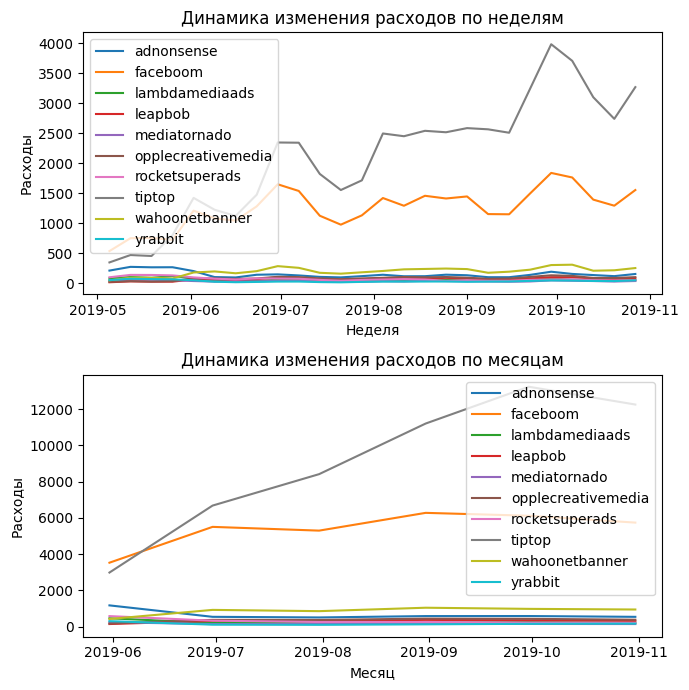

In [31]:
# Динамика изменения расходов по неделям и месяцам:

weekly_costs = costs.groupby('channel').resample('W', on='dt')['costs'].sum()
monthly_costs = costs.groupby('channel').resample('M', on='dt')['costs'].sum()

fig, ax = plt.subplots(2, 1, figsize=(7, 7))

for channel in weekly_costs.index.get_level_values(0).unique():
    ax[0].plot(weekly_costs[channel].index, weekly_costs[channel], label=channel)
ax[0].set_title('Динамика изменения расходов по неделям')
ax[0].set_xlabel('Неделя')
ax[0].set_ylabel('Расходы')
ax[0].legend()

for channel in monthly_costs.index.get_level_values(0).unique():
    ax[1].plot(monthly_costs[channel].index, monthly_costs[channel], label=channel)
ax[1].set_title('Динамика изменения расходов по месяцам')
ax[1].set_xlabel('Месяц')
ax[1].set_ylabel('Расходы')
ax[1].legend()

plt.tight_layout()
plt.show()

По динамике изменения расходов видим, что на протяжении времени канал: TipTop и FaceBoom  активно вкладываются в рекламу.

In [32]:
# Рассчет CAC ('acquisition_cost'):
average_cost = profiles.groupby('channel')['acquisition_cost'].mean()
print(average_cost)

channel
adnonsense            1.008054
faceboom              1.113286
lambdamediaads        0.724802
leapbob               0.210172
mediatornado          0.218717
opplecreativemedia    0.250000
organic               0.000000
rocketsuperads        0.412095
tiptop                2.799003
wahoonetbanner        0.602245
yrabbit               0.218975
Name: acquisition_cost, dtype: float64


CAC показывает, что каналы "TipTop" и "Faceboom" тратят больше остальных на привлечение клиента. Для канала "YRabbit" каждое посещение пользователя стоит в среднем 0.22, что является самым низким значением среди всех каналов. Это означает, что "YRabbit" является наиболее экономически эффективным каналом для привлечения пользователей с точки зрения затрат на привлечение одного пользователя.

In [33]:
# Рассчитываем ROI (относительную прибыльность инвестиции) для каждого канала:

def get_ROI(visits, orders, costs):

    combined_data = pd.merge(visits, orders, on='user_id')
    paying_users = combined_data[combined_data['revenue'] > 0]

    channel_stats = pd.merge(
        paying_users.groupby('channel')['revenue'].sum().reset_index(),
        costs.groupby('channel')['costs'].sum().reset_index(),
        on='channel'
    )


    channel_stats['ROI'] = (channel_stats['revenue'] - channel_stats['costs']) / channel_stats['costs'] * 100

    return channel_stats

channel_stats = get_ROI(visits, orders, costs)

channel_stats['revenue'] = channel_stats['revenue'].round(2)
channel_stats['ROI'] = channel_stats['ROI'].round(2)
channel_stats = channel_stats.sort_values(['revenue', 'ROI'], ascending=[False, False])

print(channel_stats)

              channel     revenue     costs       ROI
7              tiptop  1121217.88  54751.30   1947.84
8      wahoonetbanner   371466.73   5151.00   7111.55
6      rocketsuperads   236299.58   1833.00  12791.41
2      lambdamediaads   152780.67   1557.60   9708.72
3             leapbob   148982.99   1797.60   8187.88
5  opplecreativemedia   131603.00   2151.25   6017.51
9             yrabbit   111412.80    944.22  11699.45
4        mediatornado   100533.16    954.48  10432.77
1            faceboom    65434.72  32445.60    101.68
0          adnonsense    16493.79   3911.25    321.70


Относительно стоимости рекламы, высокий ROI на каналах Rocketsuperads,  Yrabbit, Mediatornado, Lambdamediaads.

In [34]:
# Вывод прибыли за 180 дней:
profit = channel_stats[ 'revenue'].sum()-total_costs
print(profit)

2350728.0200000005


In [35]:
# Рассчет cебестоимости продукции с учетом вычета:

tax_rate = 20 / 100 # налог на прибыль
loan_interest_rate = 10 / 100 # процентная ставка по кредитам
amortization_rate = 15 / 100  # ставка амортизации
asset_revaluation_rate = -5 / 100  # ставка оценки активов

tax = profit * tax_rate
loan_interest = profit * loan_interest_rate
amortization = profit * amortization_rate
asset_revaluation = profit * asset_revaluation_rate

EBITDA = profit - tax - loan_interest - amortization + asset_revaluation
print(EBITDA)

1175364.0100000002


### Оценка окупаемости рекламы

**Проанализируем окупаемость рекламы c помощью графиков**:
Пропишем функцию для сглаживания данных в DataFrame с использованием скользящего среднего, чтобы устранить шум и выбросы.

In [36]:
def filter_data(df, window):

    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean()

    return df

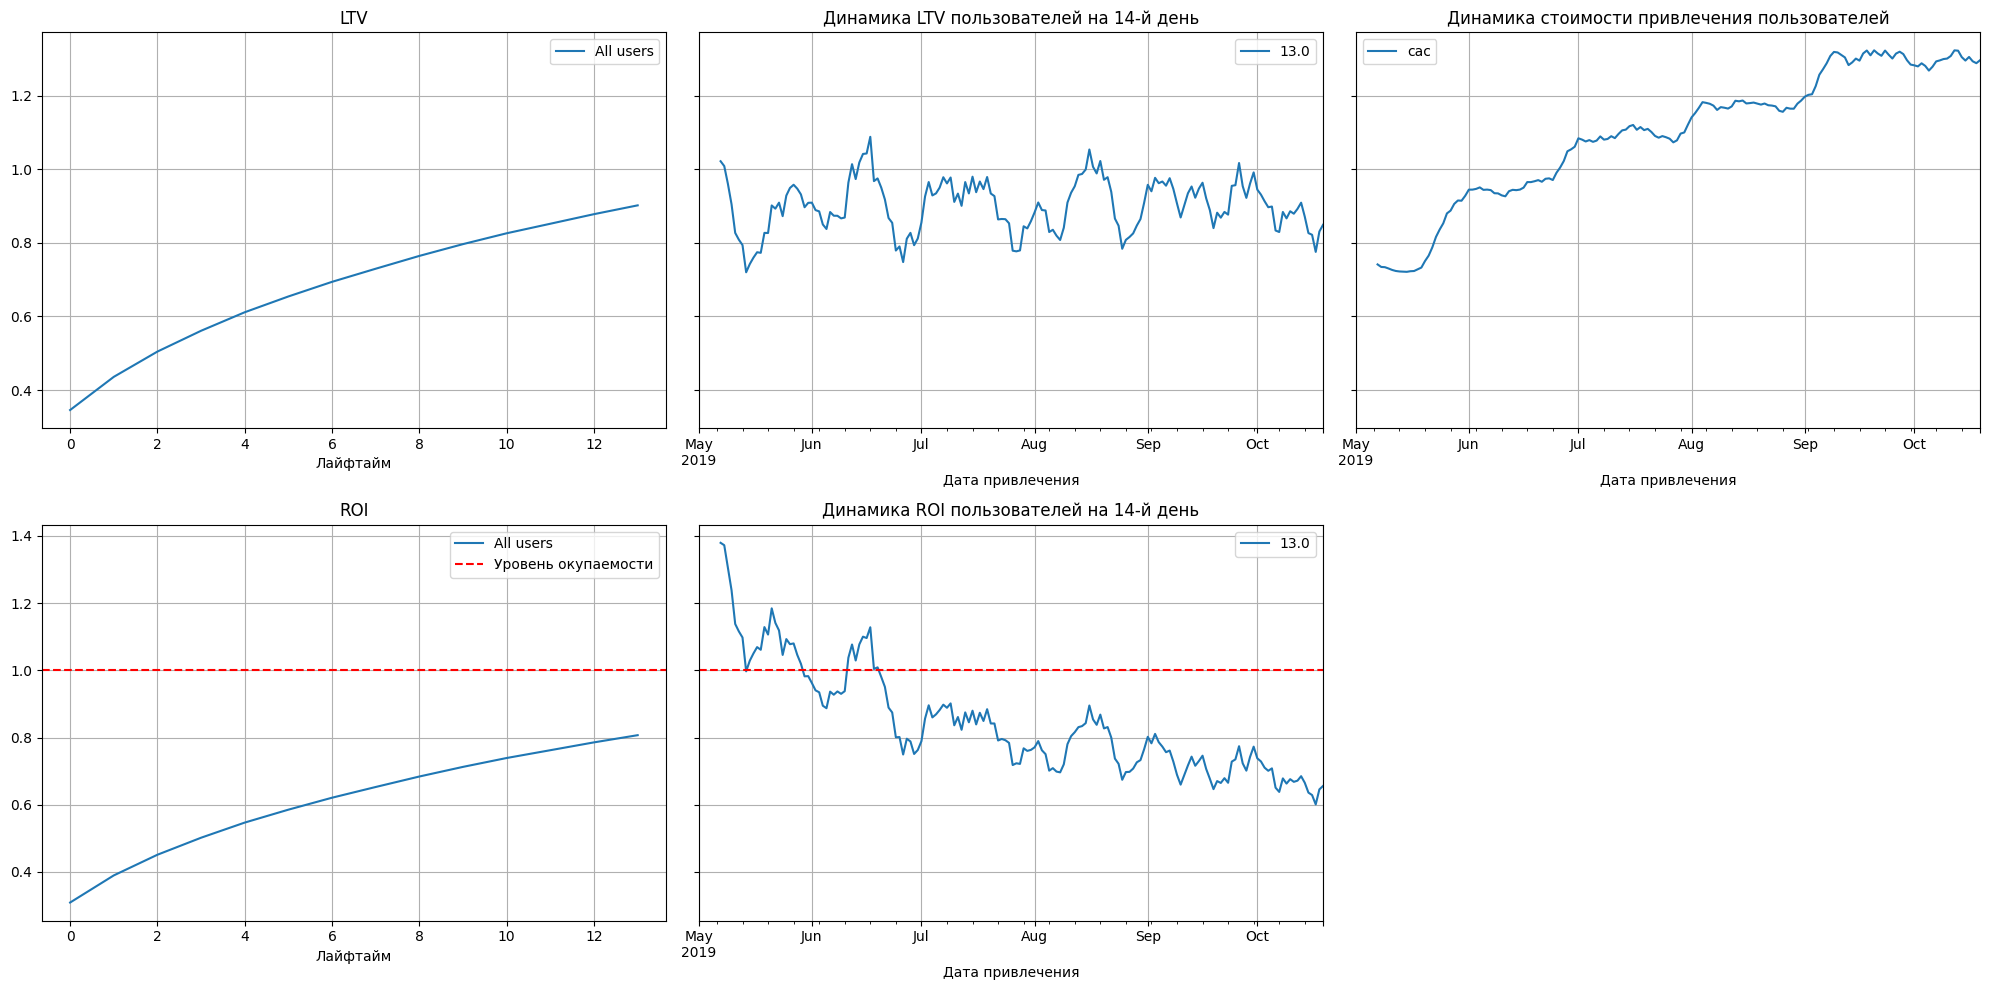

In [37]:
non_organic_profiles = profiles[profiles['acquisition_cost'] > 0]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days)

***Анализ окупаемости:***

Реклама не окупается. ROI — чуть выше 80%. CAC не стабилен. Рекламый бюджет, со временем, увеличевается. На LTV влияет сезонный фактор, этот показатель достаточно стабилен. Значит, дело не в ухудшении качества пользователей.

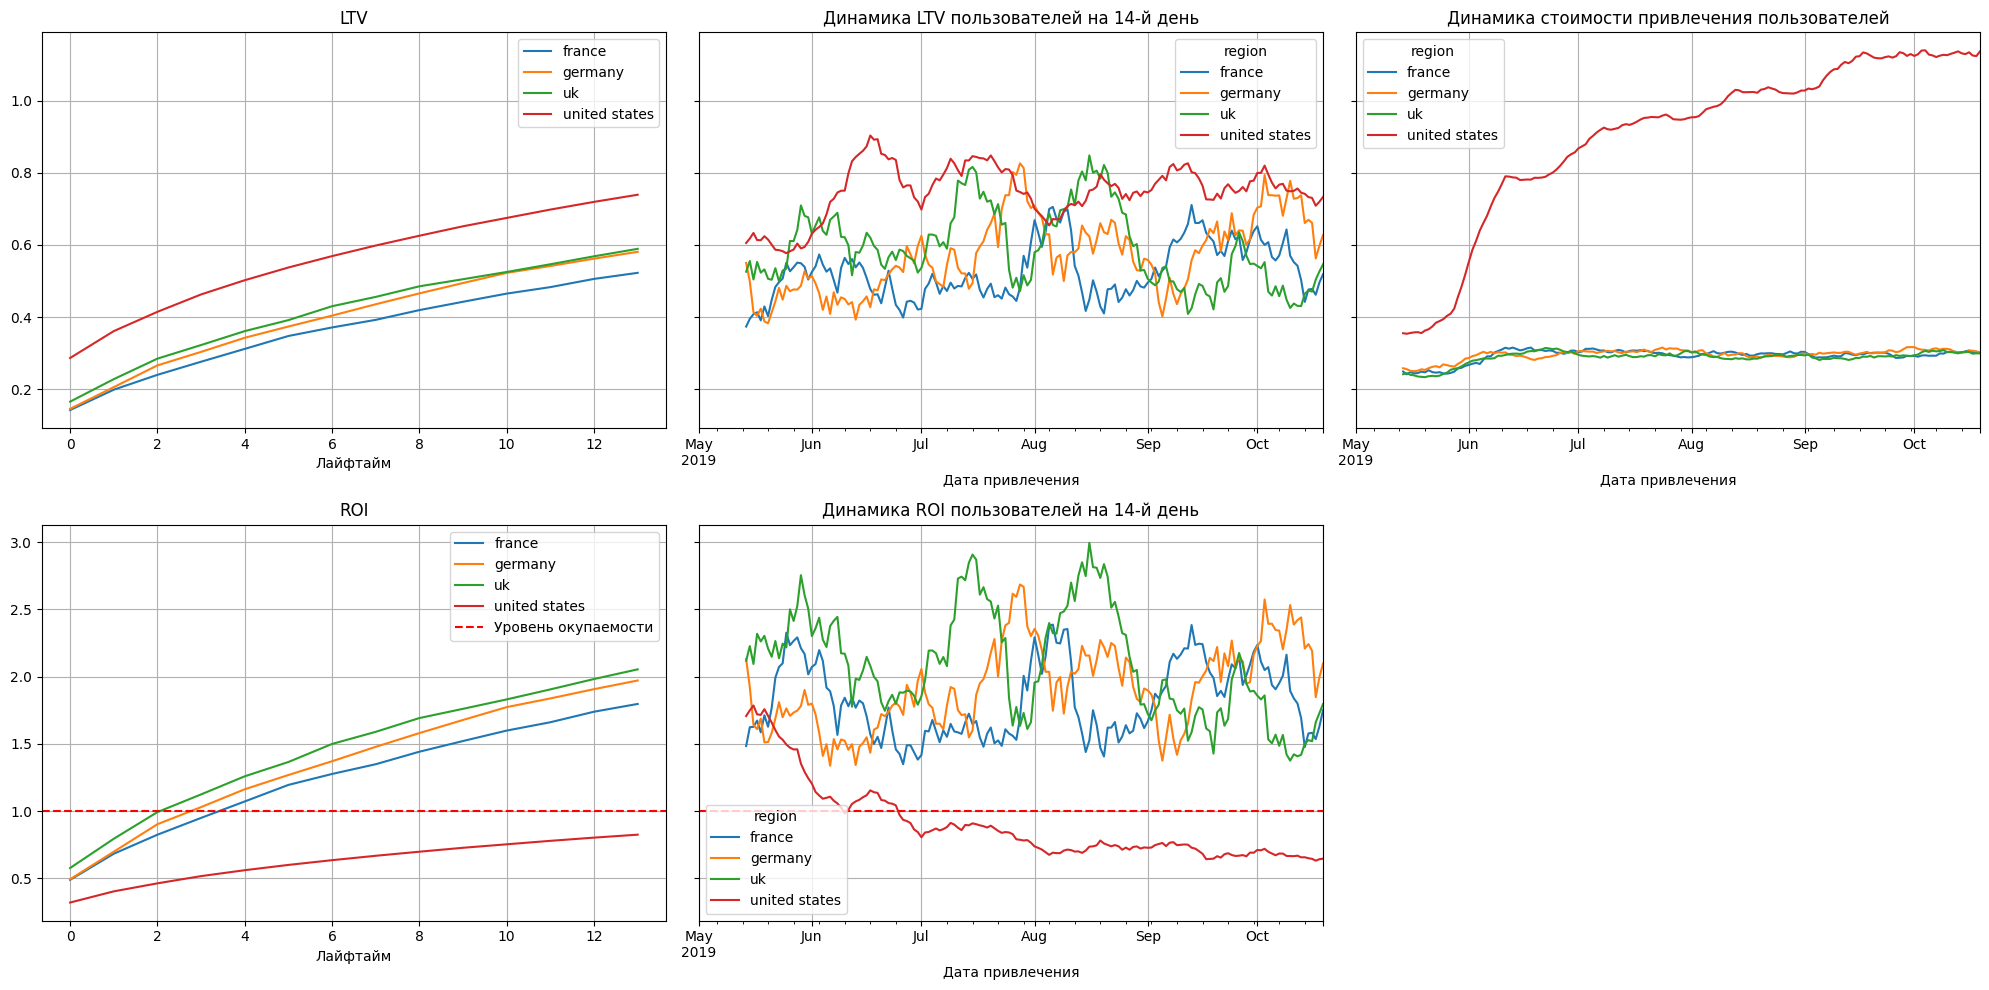

In [38]:
# Смотрим окупаемость с разбивкой по странам:

dimensions = ['region']
non_organic_profiles = profiles[profiles['acquisition_cost'] > 0]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

***Анализ окупаемости по странам:***

Реклама окупается по всем странам, кроме США. Стоимость привлечения не стабильна и возрастает по-разному для стран. LTV всё так же подвержен сезонности, но стабилен. Лучше всего окупается Великобритания. Заметные проблемы с окупаемостью в США, при относительно больших затратах на рекламу.


Факторы, которые можно рассмотреть при анализе не окупившейся рекламы в США:

1. Численность населения и демографический возраст: Размер и структура населения могут существенно влиять на эффективность рекламы. Самая большая возрастная группа США: взрослые в возрасте от 30 до 34 лет. Возрастная группа Франции, Германии, Великобритании: люди в возрасте от 40 до 64.

2. Сезонная заинтересованность: Возможно, пользователи в Франции, Германии и Великобритании используют приложение больше летом, потому что погода более умеренная, что позволяет им проводить больше времени на улице, где они могут использовать приложение. В то же время, в США летом может быть слишком жарко, чтобы проводить много времени на улице.

3. Конкуренция на рынке: Технологический рынок США очень развит, и у приложения может быть множество конкурентов, которые лучше понимают потребности и предпочтения местных пользователей. Это может объяснить, почему приложение не окупается в США, в отличие от Франции, Германии и Великобритании.

Важно провести детальный анализ конкурентов, чтобы понять, какие функции или услуги они предлагают, которые могут привлечь пользователей. Это может помочь в определении стратегии продвижения приложения и его дальнейшего развития. Кроме того, может быть полезно провести исследование рынка, чтобы лучше понять потребности и предпочтения пользователей в США. Это поможет определить, какие функции или услуги могут быть наиболее привлекательными для этой аудитории.

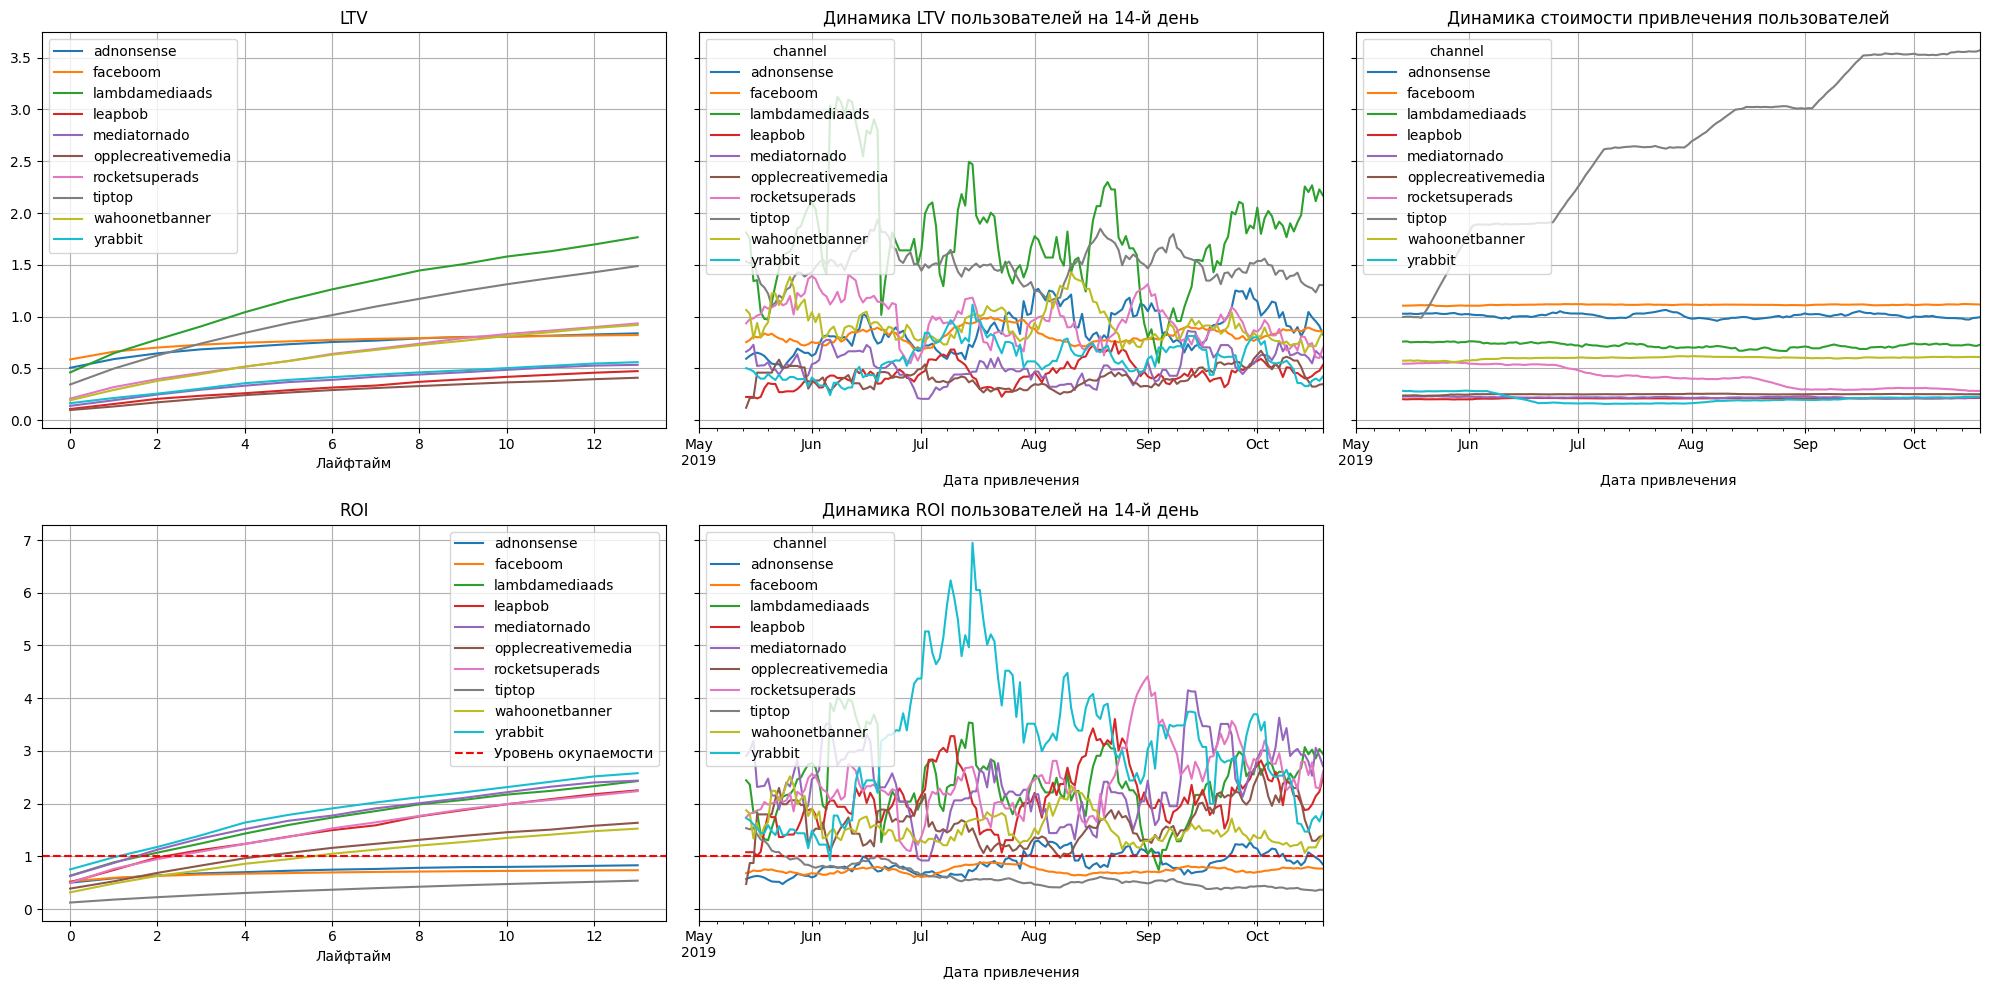

In [39]:
# Смотрим окупаемость с разбивкой по источникам привлечения

dimensions = ['channel']
non_organic_profiles = profiles[profiles['acquisition_cost'] > 0]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
    ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

***Анализ графиков окупаемости по каналам :***

Lifetime Value стабилен, что является хорошим знаком. Заметен пиковый скачок прироста пользователей в июне по каналу Lambdamediaads и с июля по август по каналу Yrabbit. Стоимость привлечения пользователей стабильна для всех каналов, кроме TipTop, где наблюдается ступенчатое увеличение затрат. Это указывает на то, что этот канал становится все менее эффективным с точки зрения затрат на привлечение клиентов. Реклама окупается почти по всем источникам привлечения, кроме Tiptop, Adnonsense, Faceboom. Заметный рост ROI по каналу Yrabbit указывает на то, что этот канал становится все более эффективным с точки зрения возврата инвестиций.

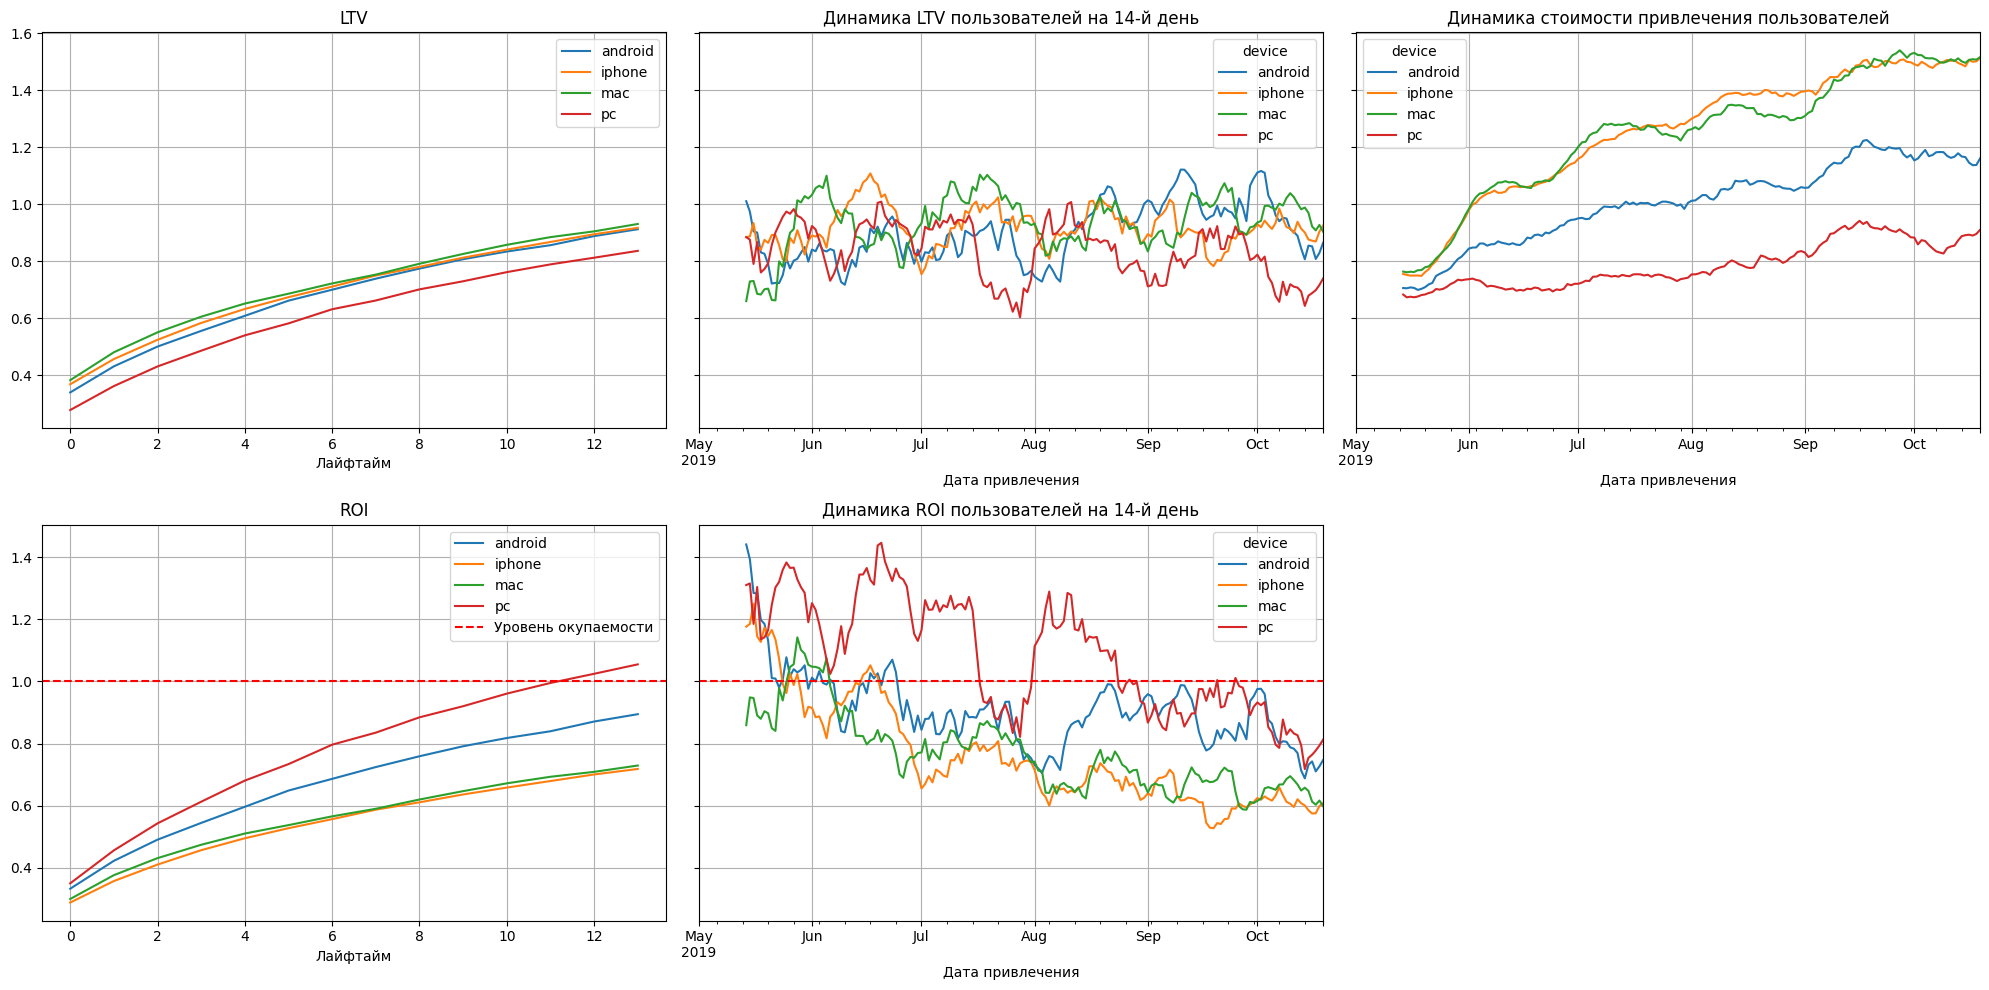

In [40]:
# Смотрим окупаемость с разбивкой по устройствам:

dimensions = ['device']
non_organic_profiles = profiles[profiles['acquisition_cost'] > 0]

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    non_organic_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(
ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14)

***Анализ окупаемости с разбивкой по устройствам:***

LTV стабилен, но подвержен сезонности, что является обычной тенденцией для многих бизнесов. Стоимость привлечения пользователей постепенно возрастает по всем устройствам, и затраты на рекламу по iPhone и Mac преобладают. Это может быть связано с тем, что пользователи этих устройств часто являются целевой аудиторией для многих компаний. Интересно, что реклама окупается на 11-й день для пользователей Android и PC.
C мая по октябрь ROI пользователей по устройствам постепенно падает, а с октября окупаемость рекламы наблюдается только у пользователей PC. Это указывает на необходимость пересмотра стратегии рекламы и на сезонные колебания в поведении пользователей.

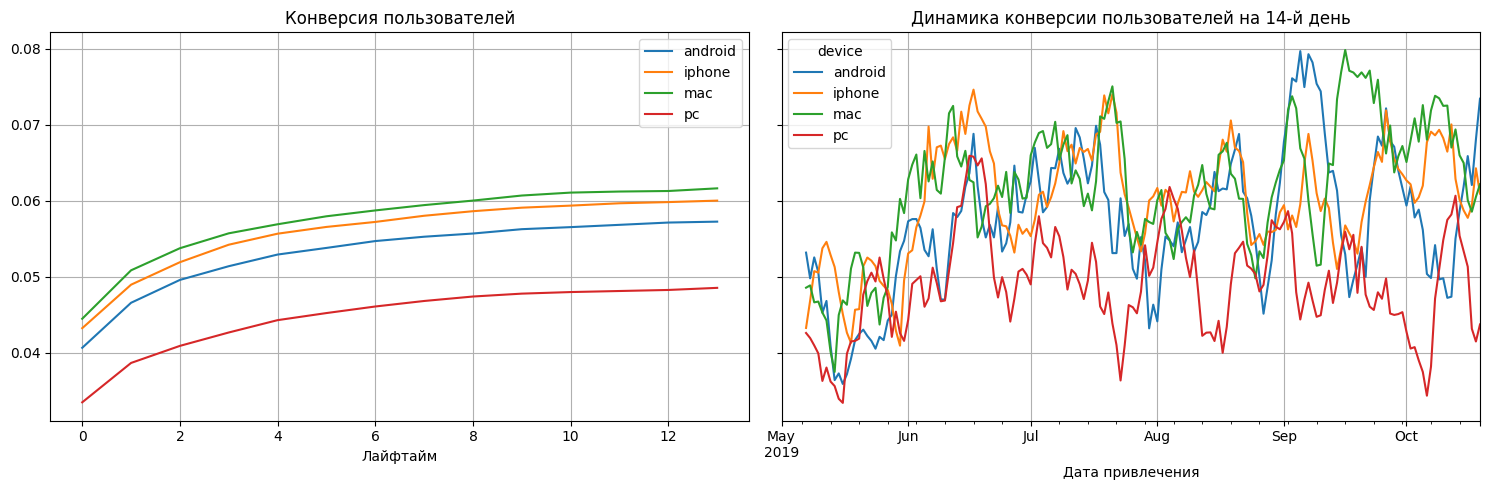

In [41]:
# Смотрим конверсию с разбивкой по устройствам:

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

С сентября по октябрь наблюдаются пиковые значения роста конверсии по пользователям Android и Mac. Определенные функции приложения могли работать лучше на этих устройствах по сравнению с другими. На основе этих наблюдений, можно рассмотреть возможность дальнейшей оптимизации приложения для устройств Android и Mac, а также исследовать, какие аспекты приложения могут быть улучшены для пользователей PC.

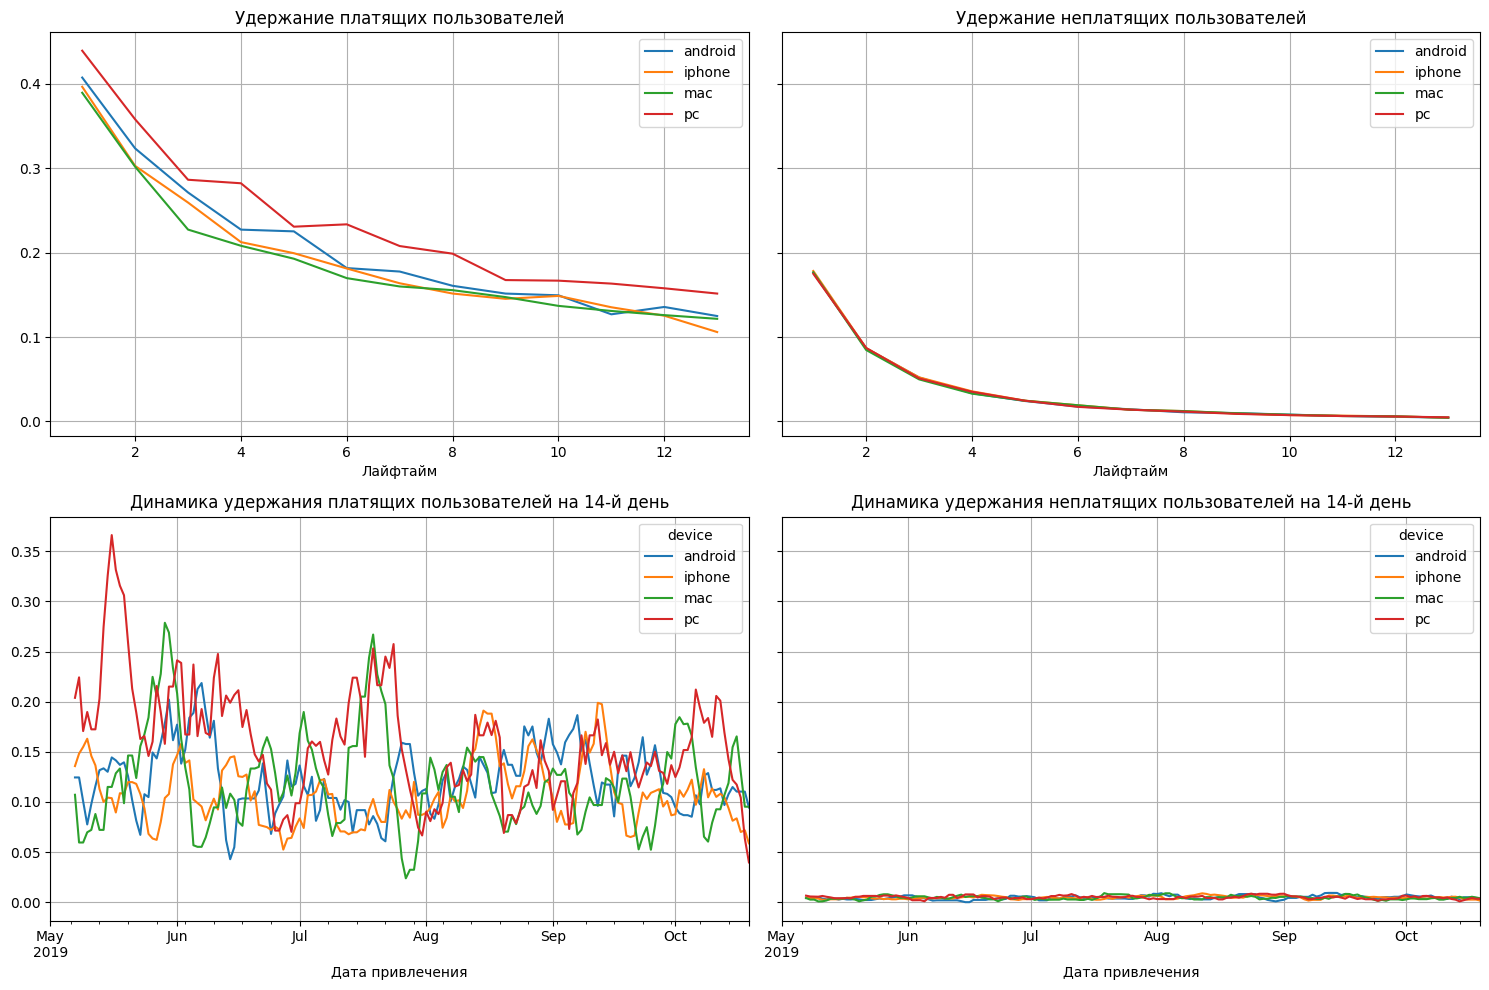

In [42]:
# Смотрим удержание с разбивкой по устройствам:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи стабильно плохо удерживаются по всем девайсам. Пик удержания платящих пользователей наблюдался в начале мая по пользователям PC.

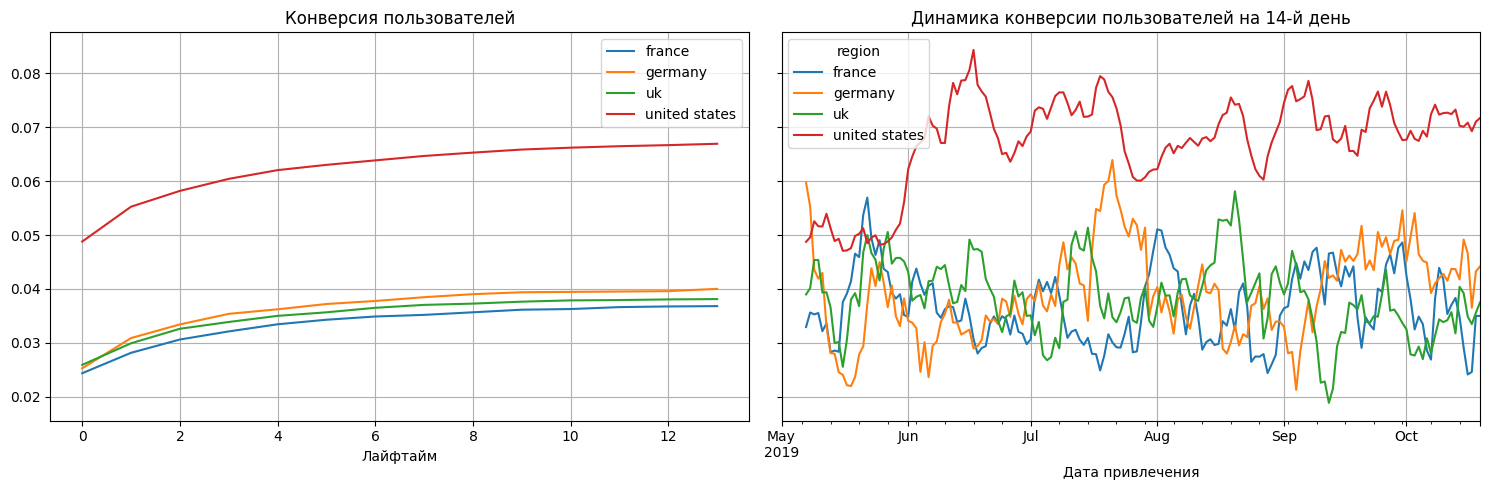

In [43]:
# Смотрим конверсию с разбивкой по регионам:

dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Высокая конверсия пользователей из Соединенных Штатов может быть связана с большой численностью населения по сравнению с Францией, Германией и Великобританией. Больше людей означает больше потенциальных пользователей для приложения.

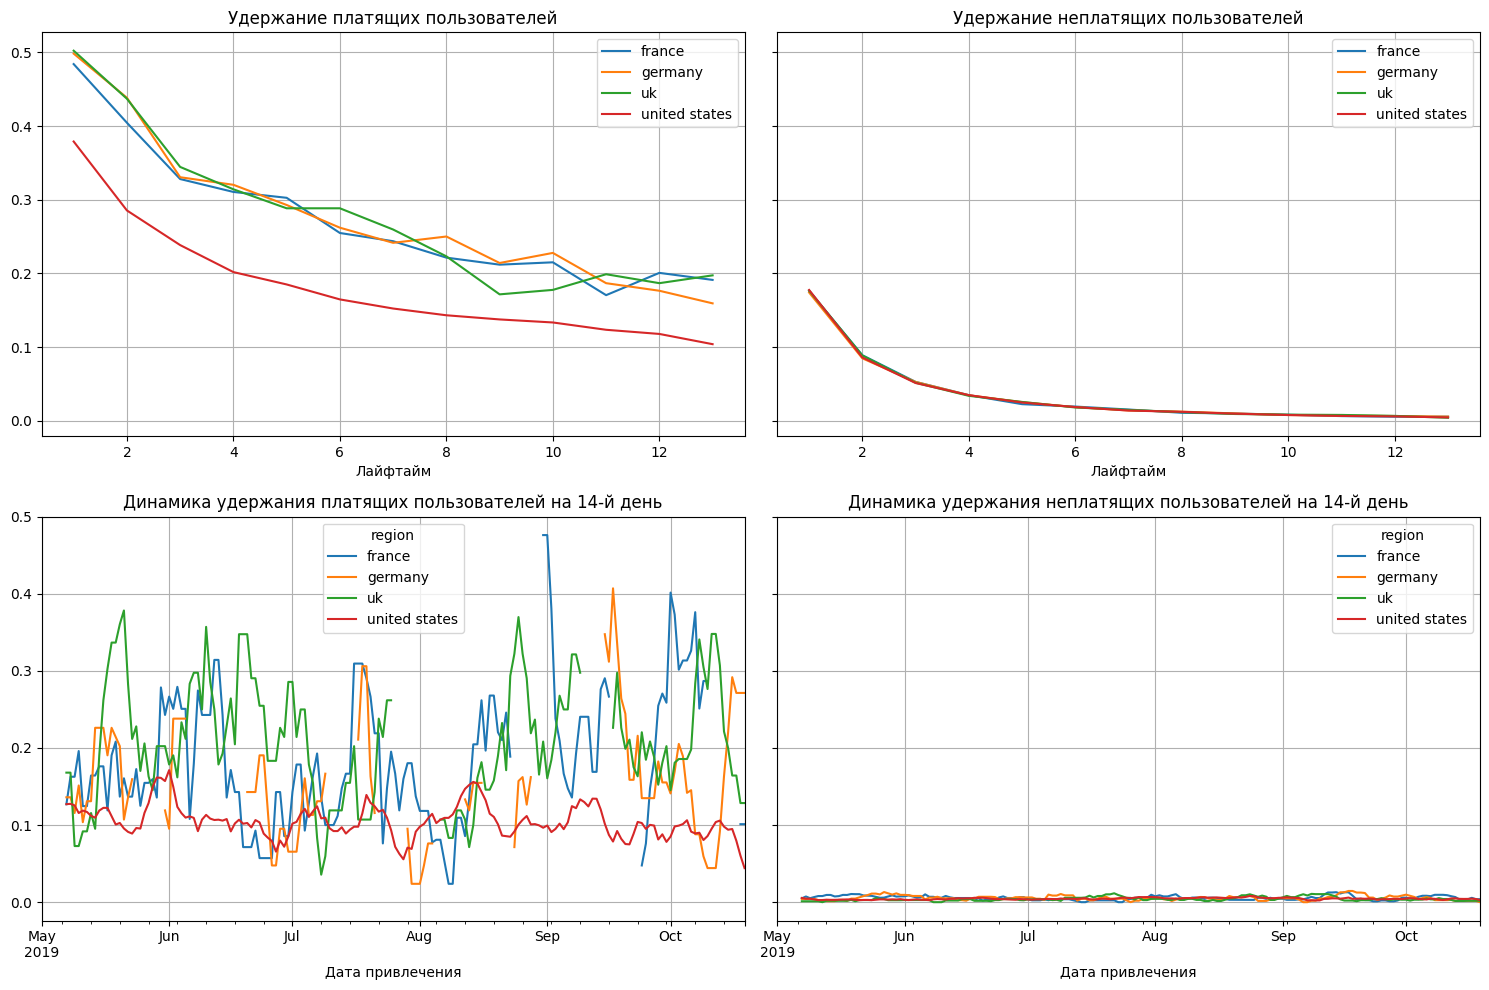

In [44]:
# Смотрим удержание с разбивкой по регионам:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

Пользователи из Великобритании стабильно удерживаются, в то время как удержание пользователей из США стабильно низкое. Это может быть связано с различиями в поведении пользователей, рыночной ситуацией или эффективностью стратегий удержания в этих регионах.
Пользователи из Франции и Германии не стабильны. Это может указывать на изменчивость рынка и на то, что стратегии удержания могут работать по-разному в разное время.

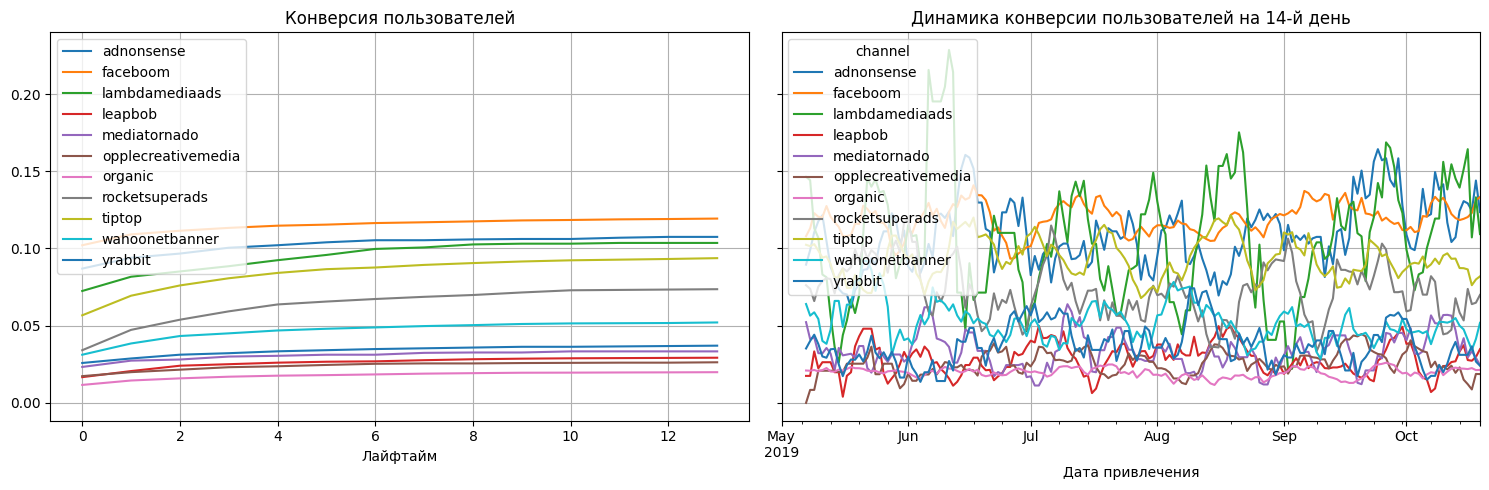

In [45]:
# Смотрим конверсию с разбивкой по каналам:

dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days)

Конверсия пользователей по каналам стабильна в течение 14 дней, что является хорошим показателем рекламной стратегии.
Cамая маленькая конверсия в динамике наблюдается по каналу Opplecreativemedia. Это указывает на необходимость пересмотра рекламной стратегии на этом канале. С другой стороны, самая высокая конверсия наблюдается по каналу Faceboom, что может быть связано с эффективностью рекламной стратегии на этом канале.

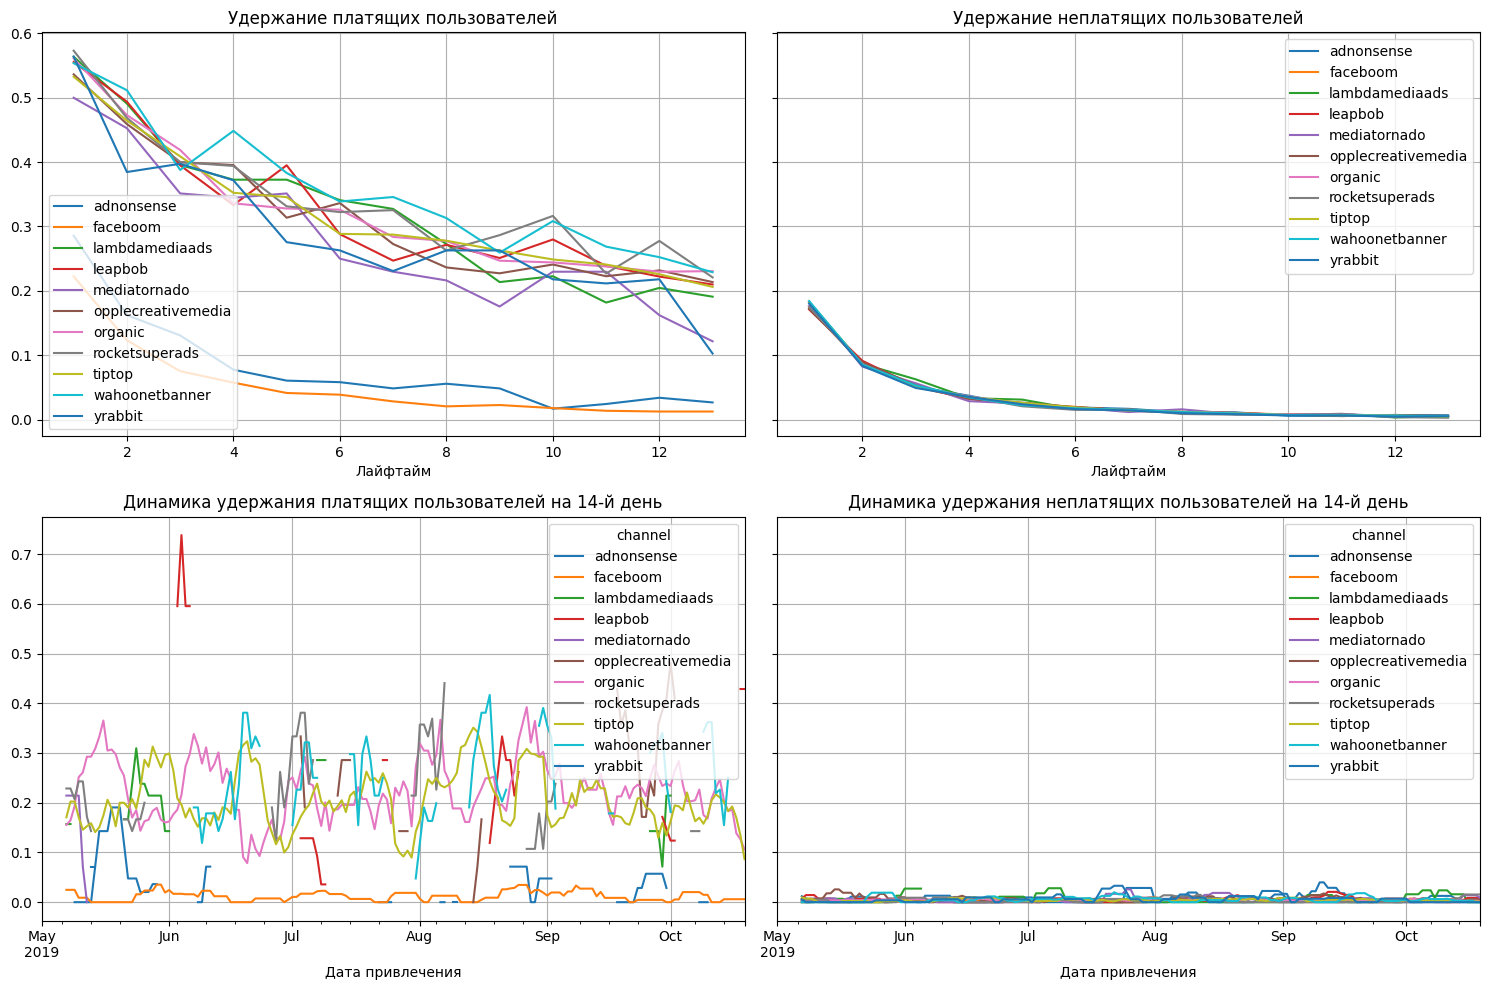

In [46]:
# Смотрим удержание с разбивкой по каналам:

retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days)

Самое низкое удержание платящих пользователей за период 14 дней наблюдается по каналам Faceboom и AdNonsense. Удержание неплатящих пользователей низкое по всем каналам. В июне на графике заметин пик пользователей по каналу LeapBob, но удержание не было длительным. Это может быть связано с временной активностью или рекламной кампанией, которая привлекла большое количество пользователей, но не смогла их удержать.

**Рекомедации рекламному отделу**:

Динамика LTV показывает, что большинство пользователей приносит небольшой доход в течение всего периода использования. Чтобы увеличить прибыль, можно оптимизировать расходы на рекламу, используя более эффективные каналы (YRabbit, MediaTornado, Wahoonetbanner, Lambdamediaads, Leapbob, Rocketsuperads,) и стратегии. Например, изучение стратегий и тактик конкурентов может помочь определить, что работает (и что не работает) на рынке(короткие видео показали себя как эффективный инструмент маркетинга). Также можно рассмотреть возможность увеличения цены базовой подписки или добавления новых функций, которые будут доступны только для платных пользователей. Это может помочь в формировании более эффективной стратегии продвижения.

Чтобы устранить сезонный спад заказов, можно провести дополнительное исследование поведения и предпочтений пользователей через опросы. Это поможет определить, какие изменения в приложении могут привести к увеличению заказов.

Наконец, вы можете рассмотреть возможность расширения рынка за счет продвижения приложения в других странах.

ROI по каналам высокий, свыше 100%. Это отличный результат, который говорит о том, что продукт востребован и прибылен.

### Выводы

**Причины неэффективности привлечения пользователей**:

- Низкая конверсия: TipTop и Faceboom имеют наибольшее общее количество пользователей, но их доля платящих пользователей относительно низкая. Эти каналы привлекают много пользователей, но большинство из них не совершают покупки. Отдел маркетинга может рассмотреть возможность оптимизации этих каналов для увеличения конверсии.

- Высокие затраты на привлечение клиентов: Каналы FaceBoom, AdnonSense, и TipTop тратят больше остальных на привлечение клиента, но имеют низкий ROI. Это указывает на неэффективность этих каналов с точки зрения затрат. Возможно, стоит пересмотреть стратегию привлечения клиентов для этих каналов и перераспределить бюджет в пользу более прибыльных каналов.

- Низкое удержание пользователей: Каналы FaceBoom и AdNonsense имеют самое низкое удержание платящих пользователей за период 14 дней. Это указывает на то, что пользователи этих каналов быстро теряют интерес к продукту. Отдел маркетинга может рассмотреть возможность улучшения стратегии удержания для этих каналов.

- Географические особенности: Реклама не окупается в США. Это может быть связано с множеством конкурентов на рынке, которые лучше понимают потребности и предпочтения местных пользователей.


**Рекомендации для отдела маркетинга**:

- Оптимизация рекламных каналов: RocketSuperAds, Yrabbit и lambdaMediaAds показывают наибольшую долю платящих пользователей. Эти каналы привлекают более ценную аудиторию. Отдел маркетинга может увеличить инвестиции в эти каналы для увеличения дохода.

- Целевые устройства: Mac и Android имеют наибольшую долю платящих пользователей. Пользователи этих устройств более склонны к покупкам. Маркетинговые кампании могут быть оптимизированы для этих платформ.

- Эффективность затрат: Каналы: YRabbit, MediaTornado, Wahoonetbanner, Lambdamediaads, Leapbob, показывают высокую окупаемость инвестиций. Отдел маркетинга может рассмотреть возможность увеличения бюджета для этих каналов.

- Географическая оптимизация: Британия и Германия являются самыми окупаемыми странами. Маркетинговые усилия могут быть увеличены в этих регионах для увеличения прибыли.

- Временные тренды: В июне на графике заметин пик пользователей по каналу LeapBob, в середине июля наблюдался заметный пик прибыли и конверсии по каналу lambdamediaads, с июля по август по каналу Yrabbit, в середине сентября по каналу MediaTornado. Отдел маркетинга может планировать будущие кампании, учитывая эти сезонные тренды.

- Удержание пользователей: Пользователи из Великобритании стабильно удерживаются, а пользователи из Соединенных Штатов показывают высокую конверсию. Эти регионы могут быть ключевыми для увеличения базы платящих пользователей.



В целом, анализ показывает положительные результаты, но требует оптимизации в выше перечисленных областях для повышения эффективности рекламных кампаний. Важно провести детальный анализ конкурентов, чтобы понять, какие функции или услуги они предлагают, которые могут привлечь пользователей. Это может помочь в определении стратегии продвижения приложения и его дальнейшего развития. Кроме того, может быть полезно провести исследование рынка, чтобы лучше понять потребности и предпочтения пользователей. Это поможет определить, какие функции или услуги могут быть наиболее привлекательными для аудитории.
